# Fine-tune ProtTrans (protein large language model) on Dephosphorylation dataset to predict Dephosphorylation sites

## Install necessary Python packages

In [3]:
!pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.


## Import packages and check versions

In [23]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
from Bio import SeqIO

from tabulate import tabulate



print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.2
Pandas version:  2.1.3
Transformers version:  4.35.2
Datasets version:  2.15.0


## Fetch and split data

In [7]:
local_fasta_path = 'train_sequences.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)

,name,sequence,label
0,sp|Q9UQC2|GAB2_HUMAN%598%614,SGTNSPAPKKSTGSVDYLALDFQPSSPSPHRKP,1
1,sp|P18031|PTN1_HUMAN%137%153,DTNLKLTLISEDIKSYYTVRQLELENLTTQETR,1
2,sp|P08581|MET_HUMAN%1340%1356,IFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSE,1
3,sp|P35968|VGFR2_HUMAN%980%996,EKSLSDVEEEEAPEDLYKDFLTLEHLICYSFQV,1
4,sp|P35568|IRS1_HUMAN%880%896,QQQPLLHPPEPKSPGEYVNIEFGSDQSGYLSGP,1


In [14]:
# Split the dataset into training and validation sets
train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

train_set=train_set[["sequence", "label"]]
valid_set=valid_set[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(train_set.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(valid_set.shape)

Training Set:
(160, 2)

Validation Set:
(41, 2)


## Define configurations for LoRA and transformer (T5) model

In [9]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [10]:
class ClassConfig:
    def __init__(self, dropout=0.9, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

## Download protein language model from HuggingFace and setup model

In [11]:
def PT5_classification_model(num_labels):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

## Set up dataset and train

In [13]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1 ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed=None #ds_config if deepspeed else None,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
        
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history


In [28]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=1, accum=8, epochs=20, seed=42)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193474
ProtT5_LoRA_Classfier
Trainable Parameter: 3559426



Epoch,Training Loss,Validation Loss,Accuracy
1,0.723500,0.683987,0.560976
2,0.698600,0.672246,0.756098
3,0.678800,0.663424,0.707317
4,0.693400,0.655698,0.707317
5,0.651500,0.645717,0.731707
6,0.647800,0.635670,0.731707
7,0.622100,0.626502,0.731707
8,0.619400,0.615508,0.731707
9,0.633700,0.603978,0.756098
10,0.626700,0.589819,0.756098


## Analyse results

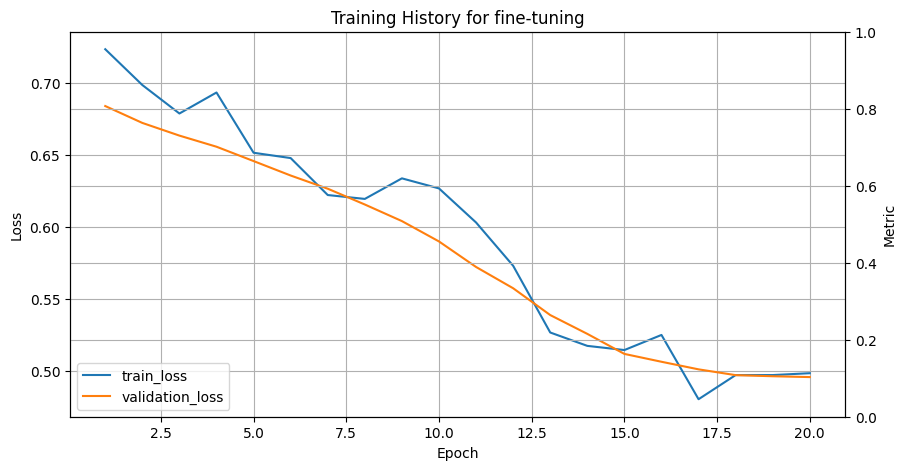

In [29]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"Training_History_new.pdf")
plt.show()

In [30]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [31]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

save_model(model, "../finetuned_model.pth")

In [32]:
tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193474
ProtT5_LoRA_Classfier
Trainable Parameter: 3559426



In [33]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [34]:
local_fasta_path = 'test_sequences.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)

,name,sequence,label
0,sp|P20963|CD3Z_HUMAN%126%142,IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM,1
1,sp|P00533|EGFR_HUMAN%1076%1092,ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP,1
2,sp|P08581|MET_HUMAN%1349%1365,YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT,1
3,sp|P09619|PGFRB_HUMAN%841%857,KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE,1
4,sp|Q13480|GAB1_HUMAN%573%589,VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG,1


In [35]:
test_set=df[["sequence", "label"]]

print(test_set.head(5))

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
test_set.loc[:, "sequence"] = test_set["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
test_set.loc[:, 'sequence'] = test_set.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM      1
1  ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP      1
2  YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT      1
3  KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE      1
4  VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG      1


In [36]:
# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(test_set['sequence']),list(test_set['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.478716 |      0.769231 |      0.708333 |       0.74 |   0.80609 |
+----------+---------------+---------------+------------+-----------+
[[20  6]
 [ 7 17]]


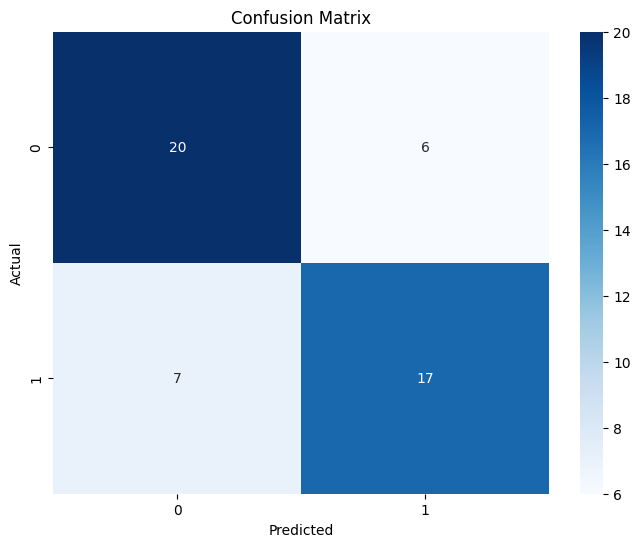

In [37]:
# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"Confusion_matrix_for_dephos.pdf")
plt.show()
